In [30]:
# Import findspark and initialize. 
import findspark
findspark.init()

In [31]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [75]:
# 1. Read in the AWS S3 bucket into a DataFrame.
from pyspark import SparkFiles
url = "https://2u-data-curriculum-team.s3.amazonaws.com/dataviz-classroom/v1.2/22-big-data/home_sales_revised.csv"

spark.sparkContext.addFile(url)
homes_sales = spark.read.csv(SparkFiles.get("home_sales_revised.csv"), sep=",", header=True)

# Show DataFrame
home_sales.show()

+--------------------+-------------------+----------+------+--------+---------+-----------+--------+------+----------+----+
|                  id|               date|date_built| price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|
+--------------------+-------------------+----------+------+--------+---------+-----------+--------+------+----------+----+
|f8a53099-ba1c-47d...|2022-04-08 00:00:00|      2016|936923|       4|        3|       3167|   11733|     2|         1|  76|
|7530a2d8-1ae3-451...|2021-06-13 00:00:00|      2013|379628|       2|        2|       2235|   14384|     1|         0|  23|
|43de979c-0bf0-4c9...|2019-04-12 00:00:00|      2014|417866|       2|        2|       2127|   10575|     2|         0|   0|
|b672c137-b88c-48b...|2019-10-16 00:00:00|      2016|239895|       2|        2|       1631|   11149|     2|         0|   0|
|e0726d4d-d595-407...|2022-01-08 00:00:00|      2017|424418|       3|        2|       2249|   13878|     2|         0|   4|
|5aa0052

In [41]:
# 2. Create a temporary view of the DataFrame.
home_sales.createOrReplaceTempView("home_sales")

# Verify that the view was created
spark.sql("SELECT * FROM home_sales").show()

+--------------------+-------------------+----------+------+--------+---------+-----------+--------+------+----------+----+
|                  id|               date|date_built| price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|
+--------------------+-------------------+----------+------+--------+---------+-----------+--------+------+----------+----+
|f8a53099-ba1c-47d...|2022-04-08 00:00:00|      2016|936923|       4|        3|       3167|   11733|     2|         1|  76|
|7530a2d8-1ae3-451...|2021-06-13 00:00:00|      2013|379628|       2|        2|       2235|   14384|     1|         0|  23|
|43de979c-0bf0-4c9...|2019-04-12 00:00:00|      2014|417866|       2|        2|       2127|   10575|     2|         0|   0|
|b672c137-b88c-48b...|2019-10-16 00:00:00|      2016|239895|       2|        2|       1631|   11149|     2|         0|   0|
|e0726d4d-d595-407...|2022-01-08 00:00:00|      2017|424418|       3|        2|       2249|   13878|     2|         0|   4|
|5aa0052

In [63]:
# 3. What is the average price for a four bedroom house sold in each year rounded to two decimal places?
avgprice_4bed = spark.sql("SELECT YEAR(date) AS year, ROUND(AVG(price), 2) AS avg_price FROM home_sales WHERE bedrooms = 4 GROUP BY year ORDER BY year desc")
avgprice_4bed.show()

+----+---------+
|year|avg_price|
+----+---------+
|2022|296363.88|
|2021|301819.44|
|2020|298353.78|
|2019| 300263.7|
+----+---------+



In [43]:
# 4. What is the average price of a home for each year the home was built that have 3 bedrooms and 3 bathrooms rounded to two decimal places?

from pyspark.sql.functions import avg

# # filter for only homes with 3 bedrooms and 3 bathrooms
# filtered_df = df.filter((df['bedrooms'] == 3) & (df['bathrooms'] == 3))

# # group by year_built and calculate the average price
# avg_price_df = filtered_df.groupBy('date_built').agg(avg('price').alias('avg_price'))

# # show the result rounded to two decimal places
# avg_price_df.show(truncate=False)

# df.filter((df['bedrooms'] == 3) & (df['bathrooms'] == 3)) \
#   .groupBy('date_built') \
#   .agg(avg('price').alias('avg_price')) \
#   .show(truncate=False)


avgprice_3bed_3bath = spark.sql("SELECT date_built, ROUND(AVG(price), 2) AS avg_price FROM home_sales WHERE bedrooms = 3 AND bathrooms = 3 GROUP BY date_built ORDER BY date_built DESC")

avgprice_3bed_3bath.show()


+----------+---------+
|date_built|avg_price|
+----------+---------+
|      2017|292676.79|
|      2016|290555.07|
|      2015| 288770.3|
|      2014|290852.27|
|      2013|295962.27|
|      2012|293683.19|
|      2011|291117.47|
|      2010|292859.62|
+----------+---------+



In [64]:
#  5. What is the average price of a home for each year built that have 3 bedrooms, 3 bathrooms, with two floors,
# and are greater than or equal to 2,000 square feet rounded to two decimal places?

avgprice_3bed_3bath_2fl = spark.sql("SELECT date_built, ROUND(AVG(price), 2) AS avg_price \
                       FROM home_sales \
                       WHERE bedrooms = 3 AND bathrooms = 3 AND floors = 2 AND sqft_living >= 2000 \
                       GROUP BY date_built \
                       ORDER BY date_built DESC")

# Show the result
avgprice_3bed_3bath_2fl.show(truncate=False)

+----------+---------+
|date_built|avg_price|
+----------+---------+
|2017      |280317.58|
|2016      |293965.1 |
|2015      |297609.97|
|2014      |298264.72|
|2013      |303676.79|
|2012      |307539.97|
|2011      |276553.81|
|2010      |285010.22|
+----------+---------+



In [65]:
# 6. What is the "view" rating for the average price of a home, rounded to two decimal places, where the homes are greater than
# or equal to $350,000? Although this is a small dataset, determine the run time for this query.
start_time = time.time()
avgprice_view = """
SELECT
  view, 
  ROUND(AVG(price), 2) AS AVERAGE_PRICE
FROM home_sales
GROUP BY view
HAVING AVG(price) >= 350000
ORDER BY view desc
"""
spark.sql(avgprice_view).show()

print("--- %s seconds ---" % (time.time() - start_time))

+----+-------------+
|view|AVERAGE_PRICE|
+----+-------------+
| 100|    1026669.5|
|  99|   1061201.42|
|  98|   1053739.33|
|  97|   1129040.15|
|  96|   1017815.92|
|  95|    1054325.6|
|  94|    1033536.2|
|  93|   1026006.06|
|  92|    970402.55|
|  91|   1137372.73|
|  90|   1062654.16|
|  89|   1107839.15|
|  88|   1031719.35|
|  87|    1072285.2|
|  86|   1070444.25|
|  85|   1056336.74|
|  84|   1117233.13|
|  83|   1033965.93|
|  82|    1063498.0|
|  81|   1053472.79|
+----+-------------+
only showing top 20 rows

--- 0.2731211185455322 seconds ---


In [46]:
# 7. Cache the the temporary table home_sales.
home_sales.cache()

# create the temporary table
home_sales.createOrReplaceTempView("home_sales")

In [47]:
# 8. Check if the table is cached.
spark.catalog.isCached('home_sales')

True

In [48]:
# 9. Using the cached data, run the query that filters out the view ratings with average price 
#  greater than or equal to $350,000. Determine the runtime and compare it to uncached runtime.

start_time = time.time()

avgprice_view_cached = spark.sql("""
    SELECT view, ROUND(AVG(price), 2) AS avg_price
    FROM home_sales
    WHERE price >= 350000
    GROUP BY view
    ORDER BY view desc
""").show()


print("--- %s seconds ---" % (time.time() - start_time))




+----+----------+
|view| avg_price|
+----+----------+
| 100| 1026669.5|
|  99|1061201.42|
|  98|1053739.33|
|  97|1129040.15|
|  96|1017815.92|
|  95| 1054325.6|
|  94| 1033536.2|
|  93|1026006.06|
|  92| 970402.55|
|  91|1137372.73|
|  90|1062654.16|
|  89|1107839.15|
|  88|1031719.35|
|  87| 1072285.2|
|  86|1070444.25|
|  85|1056336.74|
|  84|1117233.13|
|  83|1033965.93|
|  82| 1063498.0|
|  81|1053472.79|
+----+----------+
only showing top 20 rows

--- 0.18812322616577148 seconds ---


In [53]:
# 10. Partition by the "date_built" field on the formatted parquet home sales data 
# Read in the parquet data
home_sales.write.partitionBy('date_built').parquet('parquet_home_sales',mode='overwrite')

In [56]:
# 11. Read the formatted parquet data.
p_homes = spark.read.parquet('parquet_home_sales')

In [58]:
# 12. Create a temporary table for the parquet data.
spark.sql('uncache table home_sales')

DataFrame[]

In [74]:
# 13. Run the query that filters out the view ratings with average price of greater than or eqaul to $350,000 
# with the parquet DataFrame. Round your average to two decimal places. 
# Determine the runtime and compare it to the cached version. 
start_time = time.time()

avgprice_view_parquet = """
SELECT
  view,
  ROUND(AVG(price), 2) AS AVERAGE_PRICE
FROM home_sales
GROUP BY view
HAVING AVG(price) >= 350000
ORDER BY view desc
"""
spark.sql(avgprice_view_parquet).show()

print("--- %s seconds ---" % (time.time() - start_time))

+----+-------------+
|view|AVERAGE_PRICE|
+----+-------------+
| 100|    1026669.5|
|  99|   1061201.42|
|  98|   1053739.33|
|  97|   1129040.15|
|  96|   1017815.92|
|  95|    1054325.6|
|  94|    1033536.2|
|  93|   1026006.06|
|  92|    970402.55|
|  91|   1137372.73|
|  90|   1062654.16|
|  89|   1107839.15|
|  88|   1031719.35|
|  87|    1072285.2|
|  86|   1070444.25|
|  85|   1056336.74|
|  84|   1117233.13|
|  83|   1033965.93|
|  82|    1063498.0|
|  81|   1053472.79|
+----+-------------+
only showing top 20 rows

--- 0.18667101860046387 seconds ---


In [71]:
# 14. Uncache the home_sales temporary table.
spark.sql('uncache table home_sales')

DataFrame[]

In [62]:
# 15. Check if the home_sales is no longer cached

if spark.catalog.isCached('home_sales'):
  print('home_sales is cached')
else:
  print('home_sales is not cached')


home_sales is not cached


. Answer the following questions:

- What is the average price for a four-bedroom house sold for each year? Round off your answer to two decimal places.

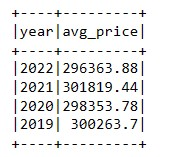



- What is the average price of a home for each year it was built that has three bedrooms and three bathrooms? Round off your answer to two decimal places.


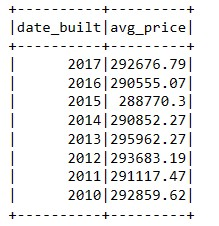



- What is the average price of a home for each year that has three bedrooms, three bathrooms, two floors, and is greater than or equal to 2,000 square feet? Round off your answer to two decimal places.


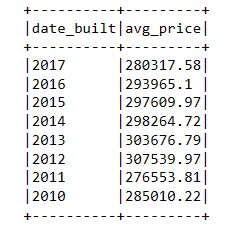


- What is the "view" rating for homes costing more than or equal to $350,000? Determine the run time for this query, and round off your answer to two decimal places.

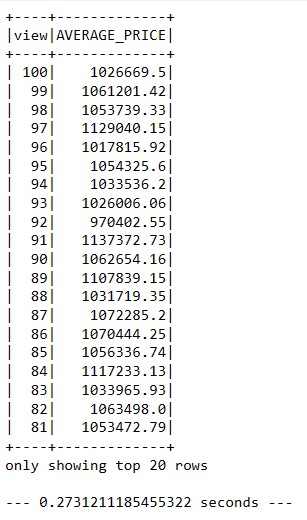

Run time : 0.2731211185455322 seconds




8. Using the cached data, run the query that filters out the view ratings with an average price of greater than or equal to $350,000. Determine the runtime and compare it to uncached runtime.

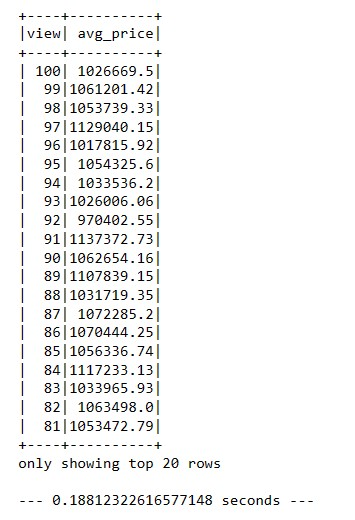

Run time : 0.18812322616577148 seconds





11. Run the query that filters out the view ratings with an average price of greater than or equal to $350,000. Determine the runtime and compare it to uncached runtime.

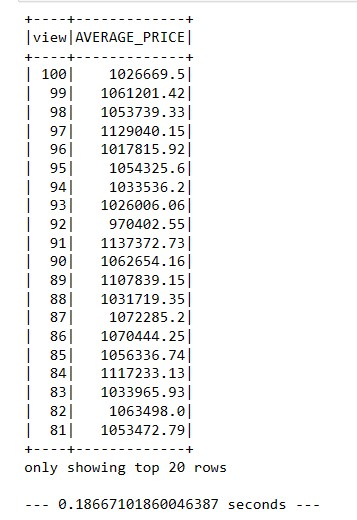

Run time : 0.18667101860046387 seconds